In [138]:
dataset_url = "https://www.kaggle.com/api/v1/datasets/download/rm1000/lung-cancer-histopathological-images"

datasetdir = "../"
basedir = ""

# install requirements in the parent folder
requirements_path = "../requirements.txt"
!pip install -r {requirements_path}


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [139]:
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms
from torchvision.io import ImageReadMode
from torchvision.io.image import decode_jpeg, read_file
from tqdm.auto import tqdm
from zipfile import ZipFile
import cv2
import torch.nn as nn
import torch.nn.functional as F
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import pandas as pd
import random
import seaborn as sns
import torch

In [140]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

import multiprocessing

num_cores = min(multiprocessing.cpu_count(), 4)

Using cuda


In [141]:
ADENOCARCINOMA = "adenocarcinoma"
SQUAMOUS_CELL_CARCINOMA = "squamous_cell_carcinoma"
BENIGN = "benign"

class_0 = BENIGN
class_1 = ADENOCARCINOMA

In [142]:
def dataset_exists(path=datasetdir + "/dataset", no_files=10000):
    # check if dir exists and contains at least no_files files
    if not os.path.exists(path):
        print(f"Folder not found in {path}")
        return False
    if len(list(glob.iglob(path + "/**", recursive=True))) < no_files:
        print(f"Not enough files in {path}")
        return False
    print(f"Dataset found in {path}")
    return True


if not dataset_exists():
    pass
    with ZipFile(datasetdir + "dataset.zip", "r") as zip_ref:
        zip_ref.extractall()
    # move folders to the right place
    os.makedirs("dataset", exist_ok=True)
    shutil.move(ADENOCARCINOMA, "dataset")
    shutil.move(SQUAMOUS_CELL_CARCINOMA, "dataset")
    shutil.move(BENIGN, "dataset")

Dataset found in ..//dataset


Number of files in benign folder: 5000
Number of files in adenocarcinoma folder: 5000
   filename   class
0  4516.jpg  benign
1  3184.jpg  benign
2  4632.jpg  benign
3  0777.jpg  benign
4  2397.jpg  benign


Text(0.5, 1.0, 'Class distribution')

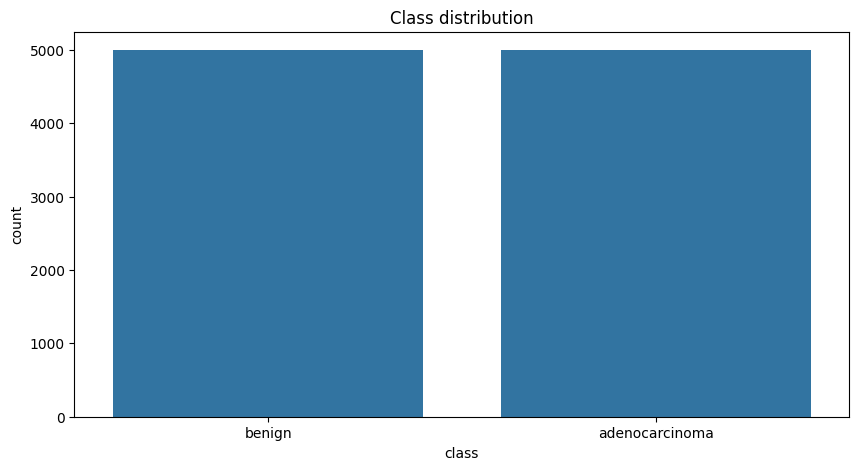

In [143]:
# Creating lists for dataframe construction
allFilesClass0 = os.listdir(f"{datasetdir}dataset/{class_0}")
allFilesClass1 = os.listdir(f"{datasetdir}dataset/{class_1}")

print(f"Number of files in {class_0} folder: {len(allFilesClass0)}")
print(f"Number of files in {class_1} folder: {len(allFilesClass1)}")

df = pd.DataFrame(columns=["filename", "class"])
df["filename"] = allFilesClass0 + allFilesClass1
df["class"] = [class_0] * len(allFilesClass0) + [class_1] * len(allFilesClass1)

# Displaying the dataframe
print(df.head())

# Displaying the class distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="class")
plt.title("Class distribution")

In [144]:
def compute_class_color(class_path):
    """
    Calcola il colore medio per una classe di immagini
    """
    rgb_means = []
    files = os.listdir(class_path)

    for file in tqdm(files, desc=f"Processing {os.path.basename(class_path)}"):
        img_path = os.path.join(class_path, file)
        img = np.array(Image.open(img_path))
        rgb_mean = np.mean(img, axis=(0, 1))
        rgb_means.append(rgb_mean)

    class_mean = np.mean(rgb_means, axis=0)
    class_std = np.std(rgb_means, axis=0)
    return class_mean, class_std


def visualize_class_colors(benign_color, cancer_color):
    """
    Visualizza i colori medi delle classi
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow([[benign_color / 255]])
    ax1.set_title("Benign Average Color")
    ax1.axis("off")

    ax2.imshow([[cancer_color / 255]])
    ax2.set_title("Cancer Average Color")
    ax2.axis("off")

    plt.show()


# Calcolo colori medi
# benign_path = "dataset/benign"
# cancer_path = f"dataset/{ADENOCARCINOMA}"
#
# benign_color, benign_std = compute_class_color(benign_path)
# cancer_color, cancer_std = compute_class_color(cancer_path)
#
# print(f"Benign average RGB: {benign_color}, std: {benign_std}")
# print(f"Cancer average RGB: {cancer_color}, std: {cancer_std}")
#
## Visualizza risultati
# visualize_class_colors(benign_color, cancer_color)

In [145]:
# Performing a stratified k-folds subdivision
KFOLDS = 10
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=42)
skf.get_n_splits(df["filename"], df["class"])

# Storing indexes to reuse them later
train_indexes = []
val_indexes = []
for train_index, val_index in skf.split(df["filename"], df["class"]):
    train_indexes.append(train_index)
    val_indexes.append(val_index)

train_splits = pd.DataFrame(columns=[f"train_{i}" for i in range(KFOLDS)])
val_splits = pd.DataFrame(columns=[f"val_{i}" for i in range(KFOLDS)])

for i in range(KFOLDS):
    train_splits[f"train_{i}"] = train_indexes[i]
    val_splits[f"val_{i}"] = val_indexes[i]

# Saving the splits
train_splits.to_csv(basedir + "train_splits.csv", index=False)
val_splits.to_csv(basedir + "val_splits.csv", index=False)

In [146]:
# recover the splits
train_splits = pd.read_csv(basedir + "train_splits.csv")
val_splits = pd.read_csv(basedir + "val_splits.csv")

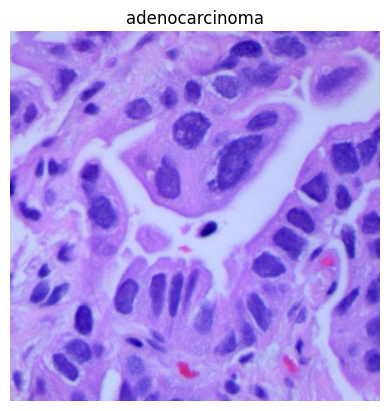

Image size: (768, 768)
Image mode: RGB


In [147]:
# image inspection
def inspect_image_randomly(df, dataset_path=datasetdir + "dataset"):
    idx = random.choice(range(len(df)))
    image = Image.open(
        f"{dataset_path}/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}"
    )
    plt.imshow(image)
    plt.title(df.iloc[idx]["class"])
    plt.axis("off")
    plt.show()
    # print metadata
    print(f"Image size: {image.size}")
    print(f"Image mode: {image.mode}")


inspect_image_randomly(df)

In [148]:
# Finding all the unique shapes of the images inside the dataset
# shapes = []
# for idx in tqdm(range(len(df))):
#    image = Image.open(f"dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}")
#    shapes.append(image.size)
#
# shapes = np.array(shapes)
# unique_shapes = np.unique(shapes, axis=0)
# print(f"Unique shapes: {unique_shapes}") # 768x768

In [149]:
TARGET_IMAGE_SIZE = 768

In [150]:
def resize_dataset(df, size):
    new_folder = datasetdir + "dataset_resized"
    os.makedirs(new_folder, exist_ok=True)
    for idx in tqdm(range(len(df))):
        # Read image with OpenCV
        img_path = (
            f"{datasetdir}dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}"
        )
        image = cv2.imread(img_path)
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize
        result = cv2.resize(gray, size)
        # Save
        dest_path = f"{new_folder}/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}"
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        cv2.imwrite(dest_path, result)


if not dataset_exists(datasetdir + "dataset_resized"):
    resize_dataset(df, (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE))

Dataset found in ../dataset_resized


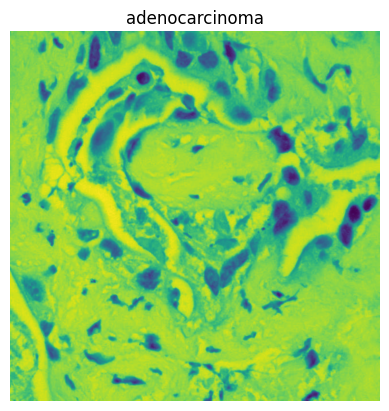

Image size: (768, 768)
Image mode: L


In [151]:
inspect_image_randomly(df, datasetdir + "dataset_resized")

In [152]:
# Calcolo colori medi
# benign_path = "dataset_resized/benign"
# cancer_path = f"dataset_resized/{ADENOCARCINOMA}"
#
# benign_color, benign_std = compute_class_color(benign_path)
# cancer_color, cancer_std = compute_class_color(cancer_path)
#
# print(f"Benign average RGB: {benign_color}, std: {benign_std}")
# print(f"Cancer average RGB: {cancer_color}, std: {cancer_std}")
#
## Visualizza risultati
# visualize_class_colors(benign_color, cancer_color)

In [153]:
class LungCancerDataset(Dataset):
    def __init__(self, df, folder_path, transform=None, cache_size=100):
        self.df = df
        self.folder_path = folder_path
        self.transform = transform
        self.cache_size = cache_size
        self.cache = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx in self.cache:
            image, label = self.cache[idx]
        else:
            img_name = self.df.iloc[idx]["filename"]
            img_class = self.df.iloc[idx]["class"]
            img_path = os.path.join(self.folder_path, img_class, img_name)

            # Load and cache image
            # image = Image.open(img_path).convert("RGB")
            # image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255
            data = read_file(img_path)
            # decode rgb
            # image = decode_jpeg(data, device=device).half() / 255
            # decode grayscale
            image = decode_jpeg(data, device=device, mode=ImageReadMode.GRAY) / 255

            label = 1 if img_class == class_1 else 0
            label = torch.tensor(label, dtype=torch.long)

            # Add to cache
            if len(self.cache) < self.cache_size:
                self.cache[idx] = (image, label)

        if self.transform:
            image = self.transform(image)

        return image, label

In [154]:
def calculate_fold_stats(df, train_idx, image_size=TARGET_IMAGE_SIZE, is_gray=True):
    """Calculate mean and std for a specific fold"""

    train_df = df.iloc[train_idx]
    train_dataset = LungCancerDataset(train_df, datasetdir + "dataset_resized")

    channels = 1 if is_gray else 3
    channels_sum = torch.zeros(
        channels, dtype=torch.float64, device=device
    )  # Use float64
    channels_squared_sum = torch.zeros(channels, dtype=torch.float64, device=device)
    pixel_count = 0

    for data, _ in tqdm(
        DataLoader(
            train_dataset,
            batch_size=1,
        ),
        desc="Calculating dataset statistics",
    ):
        data = data.to(dtype=torch.float64)
        batch_pixels = data.size(0) * data.size(2) * data.size(3)
        channels_sum += torch.sum(data, dim=[0, 2, 3])
        channels_squared_sum += torch.sum(data**2, dim=[0, 2, 3])
        pixel_count += batch_pixels

    mean = channels_sum / pixel_count

    variance = (channels_squared_sum / pixel_count) - (mean**2)
    variance = torch.clamp(variance, min=1e-10)
    std = torch.sqrt(variance)

    return mean.float(), std.float()

In [155]:
def create_dataloaders(
    df, train_idx, val_idx, mean, std, batch_size=32, image_size=TARGET_IMAGE_SIZE
):
    """Create normalized dataloaders for a specific fold"""

    # Define transforms
    train_transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomResizedCrop(768, scale=(0.8, 1.0)),
            transforms.RandomGrayscale(p=0.1),
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    # Create datasets
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_dataset = LungCancerDataset(
        train_df, datasetdir + "dataset_resized", transform=train_transform
    )
    val_dataset = LungCancerDataset(
        val_df, datasetdir + "dataset_resized", transform=val_transform
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [156]:
# Computing stats

fold_stats = {}
for fold in range(KFOLDS):
    print(f"Processing fold {fold}")
    train_idx = train_splits[f"train_{fold}"].values
    val_idx = val_splits[f"val_{fold}"].values

    # Calculate statistics for this fold
    mean, std = calculate_fold_stats(df, train_idx)
    fold_stats[fold] = {"mean": mean, "std": std}

    # Print fold statistics
    print(f"Mean: {mean}")
    print(f"Std: {std}\n")

## Save fold statistics
print("Stats: ", fold_stats)
print("Saving fold statistics...")
## delete old file
with open(basedir + "fold_stats.json", "w") as f:
    json.dump(
        {
            k: {"mean": v["mean"].tolist(), "std": v["std"].tolist()}
            for k, v in fold_stats.items()
        },
        f,
    )

Processing fold 0


Calculating dataset statistics: 100%|██████████| 9000/9000 [00:11<00:00, 804.05it/s]


Mean: tensor([0.6423], device='cuda:0')
Std: tensor([0.1705], device='cuda:0')

Processing fold 1


Calculating dataset statistics: 100%|██████████| 9000/9000 [00:11<00:00, 815.48it/s]


Mean: tensor([0.6422], device='cuda:0')
Std: tensor([0.1705], device='cuda:0')

Processing fold 2


Calculating dataset statistics: 100%|██████████| 9000/9000 [00:11<00:00, 814.44it/s]


Mean: tensor([0.6422], device='cuda:0')
Std: tensor([0.1704], device='cuda:0')

Processing fold 3


Calculating dataset statistics: 100%|██████████| 9000/9000 [00:11<00:00, 811.77it/s]


Mean: tensor([0.6424], device='cuda:0')
Std: tensor([0.1705], device='cuda:0')

Processing fold 4


Calculating dataset statistics: 100%|██████████| 9000/9000 [00:11<00:00, 808.35it/s]


Mean: tensor([0.6424], device='cuda:0')
Std: tensor([0.1704], device='cuda:0')

Processing fold 5


Calculating dataset statistics: 100%|██████████| 9000/9000 [00:11<00:00, 810.42it/s]


Mean: tensor([0.6425], device='cuda:0')
Std: tensor([0.1703], device='cuda:0')

Processing fold 6


Calculating dataset statistics: 100%|██████████| 9000/9000 [00:11<00:00, 807.13it/s]


Mean: tensor([0.6421], device='cuda:0')
Std: tensor([0.1704], device='cuda:0')

Processing fold 7


Calculating dataset statistics: 100%|██████████| 9000/9000 [00:11<00:00, 803.81it/s]


Mean: tensor([0.6425], device='cuda:0')
Std: tensor([0.1705], device='cuda:0')

Processing fold 8


Calculating dataset statistics: 100%|██████████| 9000/9000 [00:11<00:00, 808.56it/s]


Mean: tensor([0.6425], device='cuda:0')
Std: tensor([0.1704], device='cuda:0')

Processing fold 9


Calculating dataset statistics: 100%|██████████| 9000/9000 [00:11<00:00, 808.70it/s]

Mean: tensor([0.6423], device='cuda:0')
Std: tensor([0.1703], device='cuda:0')

Stats:  {0: {'mean': tensor([0.6423], device='cuda:0'), 'std': tensor([0.1705], device='cuda:0')}, 1: {'mean': tensor([0.6422], device='cuda:0'), 'std': tensor([0.1705], device='cuda:0')}, 2: {'mean': tensor([0.6422], device='cuda:0'), 'std': tensor([0.1704], device='cuda:0')}, 3: {'mean': tensor([0.6424], device='cuda:0'), 'std': tensor([0.1705], device='cuda:0')}, 4: {'mean': tensor([0.6424], device='cuda:0'), 'std': tensor([0.1704], device='cuda:0')}, 5: {'mean': tensor([0.6425], device='cuda:0'), 'std': tensor([0.1703], device='cuda:0')}, 6: {'mean': tensor([0.6421], device='cuda:0'), 'std': tensor([0.1704], device='cuda:0')}, 7: {'mean': tensor([0.6425], device='cuda:0'), 'std': tensor([0.1705], device='cuda:0')}, 8: {'mean': tensor([0.6425], device='cuda:0'), 'std': tensor([0.1704], device='cuda:0')}, 9: {'mean': tensor([0.6423], device='cuda:0'), 'std': tensor([0.1703], device='cuda:0')}}
Saving fold

In [157]:
# load fold statistics
with open(basedir + "fold_stats.json", "r") as f:
    fold_stats = json.load(f)
print(fold_stats)

{'0': {'mean': [0.6422942280769348], 'std': [0.17053534090518951]}, '1': {'mean': [0.64223313331604], 'std': [0.17051775753498077]}, '2': {'mean': [0.6422249674797058], 'std': [0.17040811479091644]}, '3': {'mean': [0.6423720717430115], 'std': [0.17045286297798157]}, '4': {'mean': [0.6424005627632141], 'std': [0.17036980390548706]}, '5': {'mean': [0.6424697637557983], 'std': [0.17031168937683105]}, '6': {'mean': [0.6421313881874084], 'std': [0.17042659223079681]}, '7': {'mean': [0.6425397992134094], 'std': [0.17047235369682312]}, '8': {'mean': [0.6425349116325378], 'std': [0.17039719223976135]}, '9': {'mean': [0.6423419117927551], 'std': [0.1703139990568161]}}


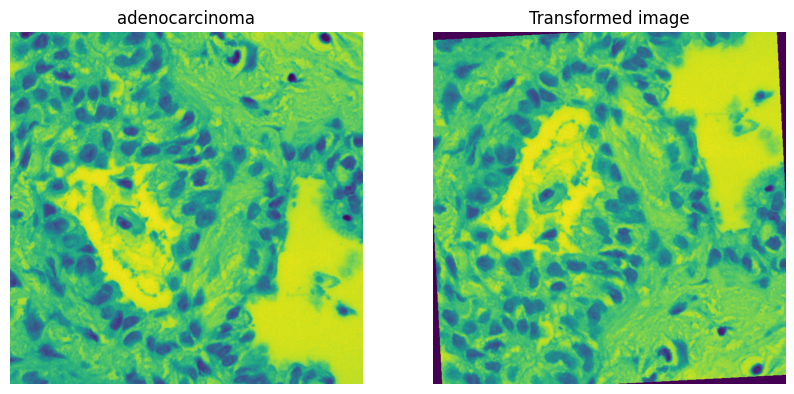

In [158]:
# Display a random image from the dataset
idx = random.choice(range(len(df)))
# read as gray scale
image = Image.open(
    f"{datasetdir}dataset_resized/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}"
)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title(df.iloc[idx]["class"])
ax[0].axis("off")

# Display the image after applying the transforms
transform = transforms.Compose(
    [
        # also add brightness change
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=fold_stats["0"]["mean"], std=fold_stats["0"]["std"]),
    ]
)

transformed_image = transform(image)
transformed_image = transformed_image.permute(1, 2, 0)

ax[1].imshow(transformed_image)
ax[1].set_title("Transformed image")
ax[1].axis("off")
plt.show()

In [159]:
# take the data from the first fold
train_idx = train_splits["train_0"].values
val_idx = val_splits["val_0"].values
mean = fold_stats["0"]["mean"]
std = fold_stats["0"]["std"]

# Create dataloaders with fold-specific normalization
train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

# check len of train and val loaders
print(f"Train loader length: {len(train_loader)}")
print(f"Val loader length: {len(val_loader)}")

Train loader length: 282
Val loader length: 32


In [160]:
# benchmark the dataloaders
# def benchmark_dataloader(loader, num_epochs=1):
#    for epoch in range(num_epochs):
#        for i, (data, target) in enumerate(tqdm(loader, desc=f"Epoch {epoch}")):
#            pass
#
#
# benchmark_dataloader(train_loader, num_epochs=1)
# benchmark_dataloader(val_loader, num_epochs=1)

In [161]:
# show the content of the first batch
# for i_batch, (images, labels) in enumerate(train_loader):
#    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
#    for i, ax in enumerate(axes.flatten()):
#        img = images[i].permute(1, 2, 0).to("cpu").float()
#        ax.imshow(img)
#        ax.set_title(f"Label: {labels[i].item()}")
#        ax.axis("off")
#        ax.set_title("Adenocarcinoma" if labels[i] == 1 else "Benign")
#    plt.tight_layout()
#    plt.show()
#    break

In [162]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 7, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 5, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)
        out = self.relu(out)
        return out


class ImageClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 11, stride=2, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )

        self.layer1 = ConvBlock(8, 16)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# Instantiate model
model = ImageClassifier()
model = model.to(device)

In [163]:
# getting a single image from the batch
images, labels = next(iter(train_loader))
print(f"Labels : {labels}")

print(f"Images shape: {images.shape}")
image = images[0].unsqueeze(0).to(device)
label = labels[0].unsqueeze(0).to(device)

# Forward pass
model.eval()
with torch.inference_mode():
    output = model(image.float())
    print(output)

# check the model summary
print(
    summary(
        model, input_size=(1, 1, TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE), device=device
    )
)

Labels : tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 1])
Images shape: torch.Size([32, 1, 768, 768])
tensor([[0.1903, 0.0480]], device='cuda:0')
Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 8, 190, 190]          --
│    └─Conv2d: 2-1                       [1, 8, 381, 381]          976
│    └─BatchNorm2d: 2-2                  [1, 8, 381, 381]          16
│    └─ReLU: 2-3                         [1, 8, 381, 381]          --
│    └─MaxPool2d: 2-4                    [1, 8, 190, 190]          --
├─ConvBlock: 1-2                         [1, 16, 184, 184]         --
│    └─Conv2d: 2-5                       [1, 16, 186, 186]         6,288
│    └─BatchNorm2d: 2-6                  [1, 16, 186, 186]         32
│    └─ReLU: 2-7                         [1, 16, 186, 186]         --
│    └─Conv

In [164]:
# from torch.profiler import profile, record_function, ProfilerActivity
#
# with profile(
#    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
#    on_trace_ready=torch.profiler.tensorboard_trace_handler("profile"),
# ) as prof:
#    for images, labels in train_loader:
#        images, labels = images.to(device), labels.to(device)
#        output = model(images.float())
#        loss = F.cross_entropy(output, labels)
#        loss.backward()
#        prof.step()
#        if prof.step_num == 40:
#            break
#
# print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
# print("Profiling finished.")

In [165]:
# Defining the operations to do in a training step
import torch.nn.utils as nn_utils


def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epoch: int,
):

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through DataLoader batches
    for _, (img, label) in enumerate(dataloader):
        # Warmup
        warmup_percent = min(epoch / 3, 1.0)
        current_lr = 5e-4 * warmup_percent
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
        # Send data to target device
        X = img.to(device)
        y = label.to(device)
        y_pred = model(X)
        # Calculate loss
        loss = loss_fn(y_pred, y)
        # Accumulate loss
        train_loss += loss.item()
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss backward
        loss.backward()
        nn_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Optimize step with scaler
        optimizer.step()
        # Calculate and accumulate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics for average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [166]:
def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for _, (img, label) in enumerate(dataloader):
            X = img.to(device)
            y = label.to(device)

            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)

            val_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [167]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 50,
    split: int = 0,
    patience: int = 5,
    min_delta: float = 0.001,
):
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Initialize early stopping variables
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=1, eta_min=1e-6
    )
    # Initialize tracking for best model
    best_val = 0

    # Training loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            epoch=epoch,
        )

        val_loss, val_acc = val_step(
            model=model, dataloader=val_dataloader, loss_fn=loss_fn
        )

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Save best model
        if val_acc > best_val:
            best_val = val_acc
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            checkpoint_name = basedir + "checkpoint_" + str(split) + ".pth"
            torch.save(checkpoint, checkpoint_name)

        # Print training progress
        tqdm.write(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    return results

In [168]:
## These lines take a lot of time; you will load the trained model in the following

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set hyperparameters
NUM_EPOCHS = 50
PATIENCE = 10
MIN_DELTA = 0.001

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# model = model.to(device)

# Train model with early stopping and LR scheduling
model_results = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    split=0,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [00:36<29:35, 36.23s/it]

Epoch: 1 | train_loss: 0.7264 | train_acc: 0.4871 | val_loss: 0.7078 | val_acc: 0.5117


  4%|▍         | 2/50 [01:12<28:50, 36.06s/it]

Epoch: 2 | train_loss: 0.5703 | train_acc: 0.7219 | val_loss: 0.5033 | val_acc: 0.8486


  6%|▌         | 3/50 [01:48<28:11, 36.00s/it]

Epoch: 3 | train_loss: 0.5150 | train_acc: 0.7910 | val_loss: 0.4479 | val_acc: 0.8643


  8%|▊         | 4/50 [02:24<27:37, 36.03s/it]

Epoch: 4 | train_loss: 0.4908 | train_acc: 0.7986 | val_loss: 0.4023 | val_acc: 0.9004


 10%|█         | 5/50 [03:00<27:02, 36.05s/it]

Epoch: 5 | train_loss: 0.4688 | train_acc: 0.8070 | val_loss: 0.3955 | val_acc: 0.8379


 12%|█▏        | 6/50 [03:36<26:26, 36.05s/it]

Epoch: 6 | train_loss: 0.4326 | train_acc: 0.8250 | val_loss: 0.3498 | val_acc: 0.8857


 14%|█▍        | 7/50 [04:12<25:51, 36.09s/it]

Epoch: 7 | train_loss: 0.4511 | train_acc: 0.8129 | val_loss: 0.2750 | val_acc: 0.9111


 16%|█▌        | 8/50 [04:48<25:15, 36.08s/it]

Epoch: 8 | train_loss: 0.4322 | train_acc: 0.8174 | val_loss: 0.2516 | val_acc: 0.9395


 18%|█▊        | 9/50 [05:24<24:39, 36.10s/it]

Epoch: 9 | train_loss: 0.3857 | train_acc: 0.8430 | val_loss: 0.3057 | val_acc: 0.9463


 20%|██        | 10/50 [06:00<24:04, 36.11s/it]

Epoch: 10 | train_loss: 0.4083 | train_acc: 0.8300 | val_loss: 0.2916 | val_acc: 0.8818


 22%|██▏       | 11/50 [06:36<23:26, 36.07s/it]

Epoch: 11 | train_loss: 0.3915 | train_acc: 0.8367 | val_loss: 0.3400 | val_acc: 0.9277


 24%|██▍       | 12/50 [07:12<22:48, 36.02s/it]

Epoch: 12 | train_loss: 0.4240 | train_acc: 0.8280 | val_loss: 0.2317 | val_acc: 0.9258


 26%|██▌       | 13/50 [07:48<22:12, 36.01s/it]

Epoch: 13 | train_loss: 0.3485 | train_acc: 0.8592 | val_loss: 0.1979 | val_acc: 0.9287


 28%|██▊       | 14/50 [08:24<21:34, 35.96s/it]

Epoch: 14 | train_loss: 0.3384 | train_acc: 0.8617 | val_loss: 0.1937 | val_acc: 0.9395


 30%|███       | 15/50 [09:00<20:59, 35.99s/it]

Epoch: 15 | train_loss: 0.3676 | train_acc: 0.8450 | val_loss: 0.4208 | val_acc: 0.7500


 32%|███▏      | 16/50 [09:36<20:19, 35.88s/it]

Epoch: 16 | train_loss: 0.3854 | train_acc: 0.8435 | val_loss: 0.4719 | val_acc: 0.7109


 34%|███▍      | 17/50 [10:13<19:56, 36.27s/it]

Epoch: 17 | train_loss: 0.3571 | train_acc: 0.8520 | val_loss: 0.4470 | val_acc: 0.7793


 36%|███▌      | 18/50 [10:51<19:39, 36.85s/it]

Epoch: 18 | train_loss: 0.3356 | train_acc: 0.8565 | val_loss: 0.2759 | val_acc: 0.8848


 38%|███▊      | 19/50 [11:29<19:13, 37.21s/it]

Epoch: 19 | train_loss: 0.3395 | train_acc: 0.8623 | val_loss: 0.3203 | val_acc: 0.8281


 40%|████      | 20/50 [12:07<18:42, 37.40s/it]

Epoch: 20 | train_loss: 0.4167 | train_acc: 0.8319 | val_loss: 0.2419 | val_acc: 0.9043


 42%|████▏     | 21/50 [12:45<18:09, 37.58s/it]

Epoch: 21 | train_loss: 0.3318 | train_acc: 0.8625 | val_loss: 0.1809 | val_acc: 0.9658


 44%|████▍     | 22/50 [13:22<17:25, 37.33s/it]

Epoch: 22 | train_loss: 0.2998 | train_acc: 0.8800 | val_loss: 0.4863 | val_acc: 0.7090


 46%|████▌     | 23/50 [13:59<16:47, 37.32s/it]

Epoch: 23 | train_loss: 0.3118 | train_acc: 0.8716 | val_loss: 0.2101 | val_acc: 0.9316


 48%|████▊     | 24/50 [14:37<16:12, 37.42s/it]

Epoch: 24 | train_loss: 0.3070 | train_acc: 0.8721 | val_loss: 0.2216 | val_acc: 0.9160


 50%|█████     | 25/50 [15:14<15:38, 37.54s/it]

Epoch: 25 | train_loss: 0.3138 | train_acc: 0.8725 | val_loss: 0.1668 | val_acc: 0.9570


 52%|█████▏    | 26/50 [15:52<15:00, 37.52s/it]

Epoch: 26 | train_loss: 0.2977 | train_acc: 0.8835 | val_loss: 0.2031 | val_acc: 0.9277


 54%|█████▍    | 27/50 [16:30<14:23, 37.56s/it]

Epoch: 27 | train_loss: 0.3102 | train_acc: 0.8751 | val_loss: 0.2312 | val_acc: 0.9111


 56%|█████▌    | 28/50 [17:08<13:53, 37.87s/it]

Epoch: 28 | train_loss: 0.3280 | train_acc: 0.8691 | val_loss: 0.2271 | val_acc: 0.9326


 58%|█████▊    | 29/50 [17:46<13:15, 37.90s/it]

Epoch: 29 | train_loss: 0.2819 | train_acc: 0.8832 | val_loss: 0.1472 | val_acc: 0.9463


 60%|██████    | 30/50 [18:24<12:34, 37.75s/it]

Epoch: 30 | train_loss: 0.2974 | train_acc: 0.8784 | val_loss: 0.3001 | val_acc: 0.8633


 62%|██████▏   | 31/50 [19:01<11:57, 37.74s/it]

Epoch: 31 | train_loss: 0.2878 | train_acc: 0.8813 | val_loss: 0.1418 | val_acc: 0.9697


 64%|██████▍   | 32/50 [19:40<11:22, 37.90s/it]

Epoch: 32 | train_loss: 0.2664 | train_acc: 0.8924 | val_loss: 0.1790 | val_acc: 0.9316


 66%|██████▌   | 33/50 [20:17<10:42, 37.79s/it]

Epoch: 33 | train_loss: 0.2773 | train_acc: 0.8873 | val_loss: 0.1262 | val_acc: 0.9678


 68%|██████▊   | 34/50 [20:54<10:00, 37.53s/it]

Epoch: 34 | train_loss: 0.2936 | train_acc: 0.8805 | val_loss: 0.2270 | val_acc: 0.9150


 70%|███████   | 35/50 [21:31<09:22, 37.48s/it]

Epoch: 35 | train_loss: 0.2727 | train_acc: 0.8871 | val_loss: 0.1460 | val_acc: 0.9600


 72%|███████▏  | 36/50 [22:08<08:42, 37.30s/it]

Epoch: 36 | train_loss: 0.2727 | train_acc: 0.8881 | val_loss: 0.1259 | val_acc: 0.9717


 74%|███████▍  | 37/50 [22:45<08:04, 37.28s/it]

Epoch: 37 | train_loss: 0.2704 | train_acc: 0.8908 | val_loss: 0.1231 | val_acc: 0.9766


 76%|███████▌  | 38/50 [23:23<07:29, 37.47s/it]

Epoch: 38 | train_loss: 0.2511 | train_acc: 0.9023 | val_loss: 0.6534 | val_acc: 0.6885


 78%|███████▊  | 39/50 [24:01<06:53, 37.59s/it]

Epoch: 39 | train_loss: 0.2656 | train_acc: 0.8920 | val_loss: 0.4454 | val_acc: 0.7969


 80%|████████  | 40/50 [24:40<06:18, 37.86s/it]

Epoch: 40 | train_loss: 0.2902 | train_acc: 0.8836 | val_loss: 0.5397 | val_acc: 0.6689


 82%|████████▏ | 41/50 [25:19<05:43, 38.15s/it]

Epoch: 41 | train_loss: 0.2531 | train_acc: 0.8969 | val_loss: 0.1354 | val_acc: 0.9697


 84%|████████▍ | 42/50 [25:57<05:04, 38.10s/it]

Epoch: 42 | train_loss: 0.2572 | train_acc: 0.8949 | val_loss: 0.3325 | val_acc: 0.8184


 86%|████████▌ | 43/50 [26:34<04:25, 37.95s/it]

Epoch: 43 | train_loss: 0.2479 | train_acc: 0.8979 | val_loss: 0.1155 | val_acc: 0.9697


 88%|████████▊ | 44/50 [27:12<03:47, 37.95s/it]

Epoch: 44 | train_loss: 0.2516 | train_acc: 0.8972 | val_loss: 0.1828 | val_acc: 0.9404


 90%|█████████ | 45/50 [27:51<03:11, 38.21s/it]

Epoch: 45 | train_loss: 0.2357 | train_acc: 0.9049 | val_loss: 0.2754 | val_acc: 0.8877


 92%|█████████▏| 46/50 [28:30<02:33, 38.34s/it]

Epoch: 46 | train_loss: 0.2404 | train_acc: 0.9000 | val_loss: 0.1603 | val_acc: 0.9385


 94%|█████████▍| 47/50 [29:08<01:55, 38.37s/it]

Epoch: 47 | train_loss: 0.2558 | train_acc: 0.8962 | val_loss: 0.2718 | val_acc: 0.8740


 96%|█████████▌| 48/50 [29:47<01:17, 38.53s/it]

Epoch: 48 | train_loss: 0.2338 | train_acc: 0.9106 | val_loss: 0.1800 | val_acc: 0.9346


 98%|█████████▊| 49/50 [30:24<00:38, 38.20s/it]

Epoch: 49 | train_loss: 0.2446 | train_acc: 0.9020 | val_loss: 0.1128 | val_acc: 0.9727


100%|██████████| 50/50 [31:01<00:00, 37.24s/it]

Epoch: 50 | train_loss: 0.2556 | train_acc: 0.8987 | val_loss: 0.2358 | val_acc: 0.8984
Total training time: 1861.801 seconds


In [169]:
## These are the results from the previous step; you will load the results in the following

# Extract train and validation loss and accuracy at each epoch
results = dict(list(model_results.items()))

# Get the loss values of the results dictionary (training and validation)
train_loss = results["train_loss"]
val_loss = results["val_loss"]

# Get the accuracy values of the results dictionary (training and validation)
train_acc = results["train_acc"]
val_acc = results["val_acc"]

# Figure out how many epochs there were
epochs = range(len(results["train_loss"]))
print("epochs: ", epochs)

epochs:  range(0, 50)


In [170]:
## Save results in a csv
results_df = pd.DataFrame(
    columns=["train_loss", "val_loss", "train_acc", "val_acc", "epochs"]
)
results_df["train_loss"] = train_loss
results_df["val_loss"] = val_loss
results_df["train_acc"] = train_acc
results_df["val_acc"] = val_acc
results_df["epochs"] = epochs
results_df_name = basedir + "results_df_" + str(0) + ".csv"
results_df.to_csv(results_df_name)

print("df: ", results_df)

df:      train_loss  val_loss  train_acc   val_acc  epochs
0     0.726406  0.707827   0.487145  0.511719       0
1     0.570264  0.503326   0.721853  0.848633       1
2     0.515026  0.447917   0.791002  0.864258       2
3     0.490797  0.402280   0.798648  0.900391       3
4     0.468760  0.395523   0.806959  0.837891       4
5     0.432622  0.349753   0.825022  0.885742       5
6     0.451150  0.274969   0.812943  0.911133       6
7     0.432228  0.251649   0.817376  0.939453       7
8     0.385728  0.305747   0.842974  0.946289       8
9     0.408332  0.291620   0.830009  0.881836       9
10    0.391529  0.339982   0.836658  0.927734      10
11    0.424036  0.231674   0.828014  0.925781      11
12    0.348508  0.197860   0.859153  0.928711      12
13    0.338372  0.193735   0.861702  0.939453      13
14    0.367593  0.420786   0.844969  0.750000      14
15    0.385359  0.471875   0.843528  0.710938      15
16    0.357083  0.446971   0.851950  0.779297      16
17    0.335551  0.27589

In [171]:
results_from_csv = pd.read_csv(basedir + "results_df_0.csv")

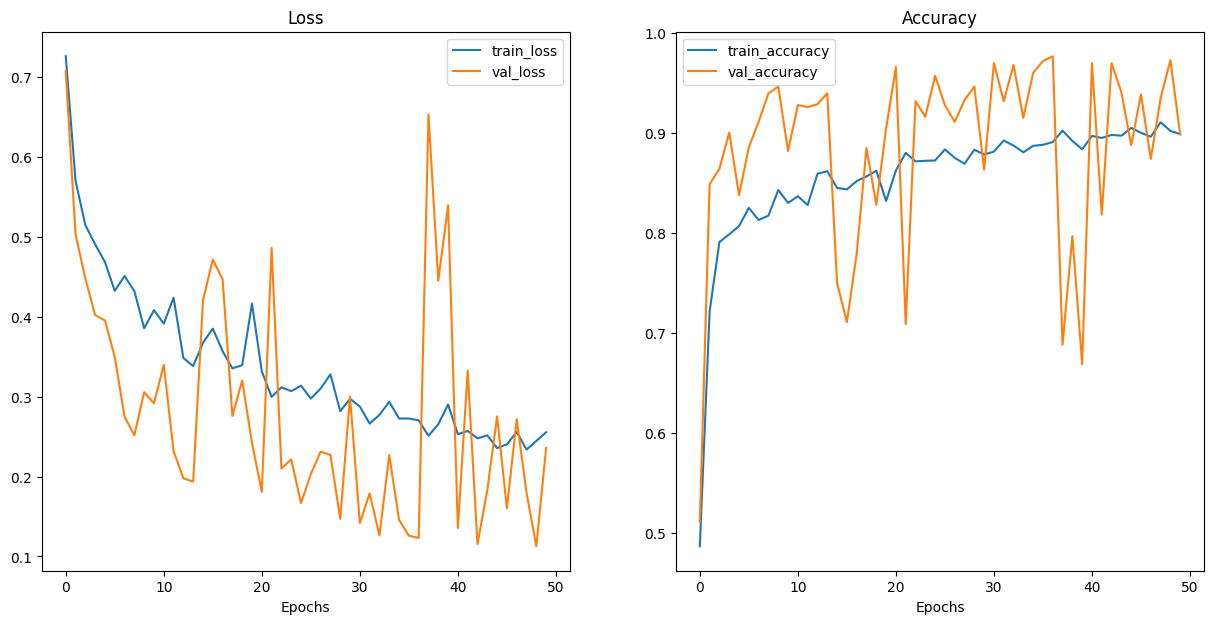

In [172]:
# Setup a plot
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(results_from_csv["epochs"], results_from_csv["train_loss"], label="train_loss")
plt.plot(results_from_csv["epochs"], results_from_csv["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(
    results_from_csv["epochs"], results_from_csv["train_acc"], label="train_accuracy"
)
plt.plot(results_from_csv["epochs"], results_from_csv["val_acc"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

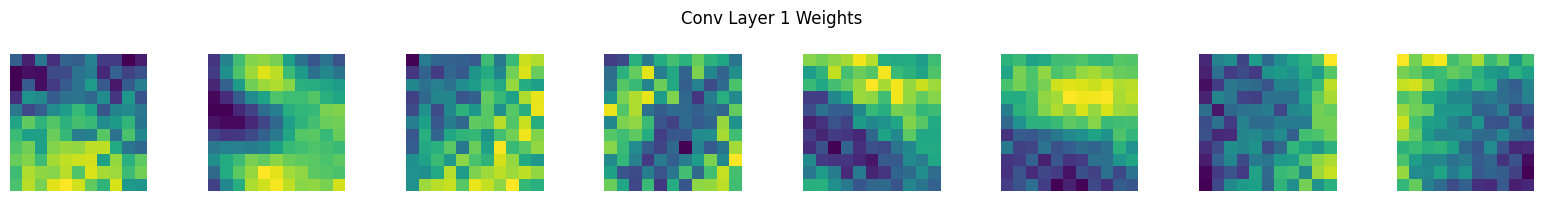

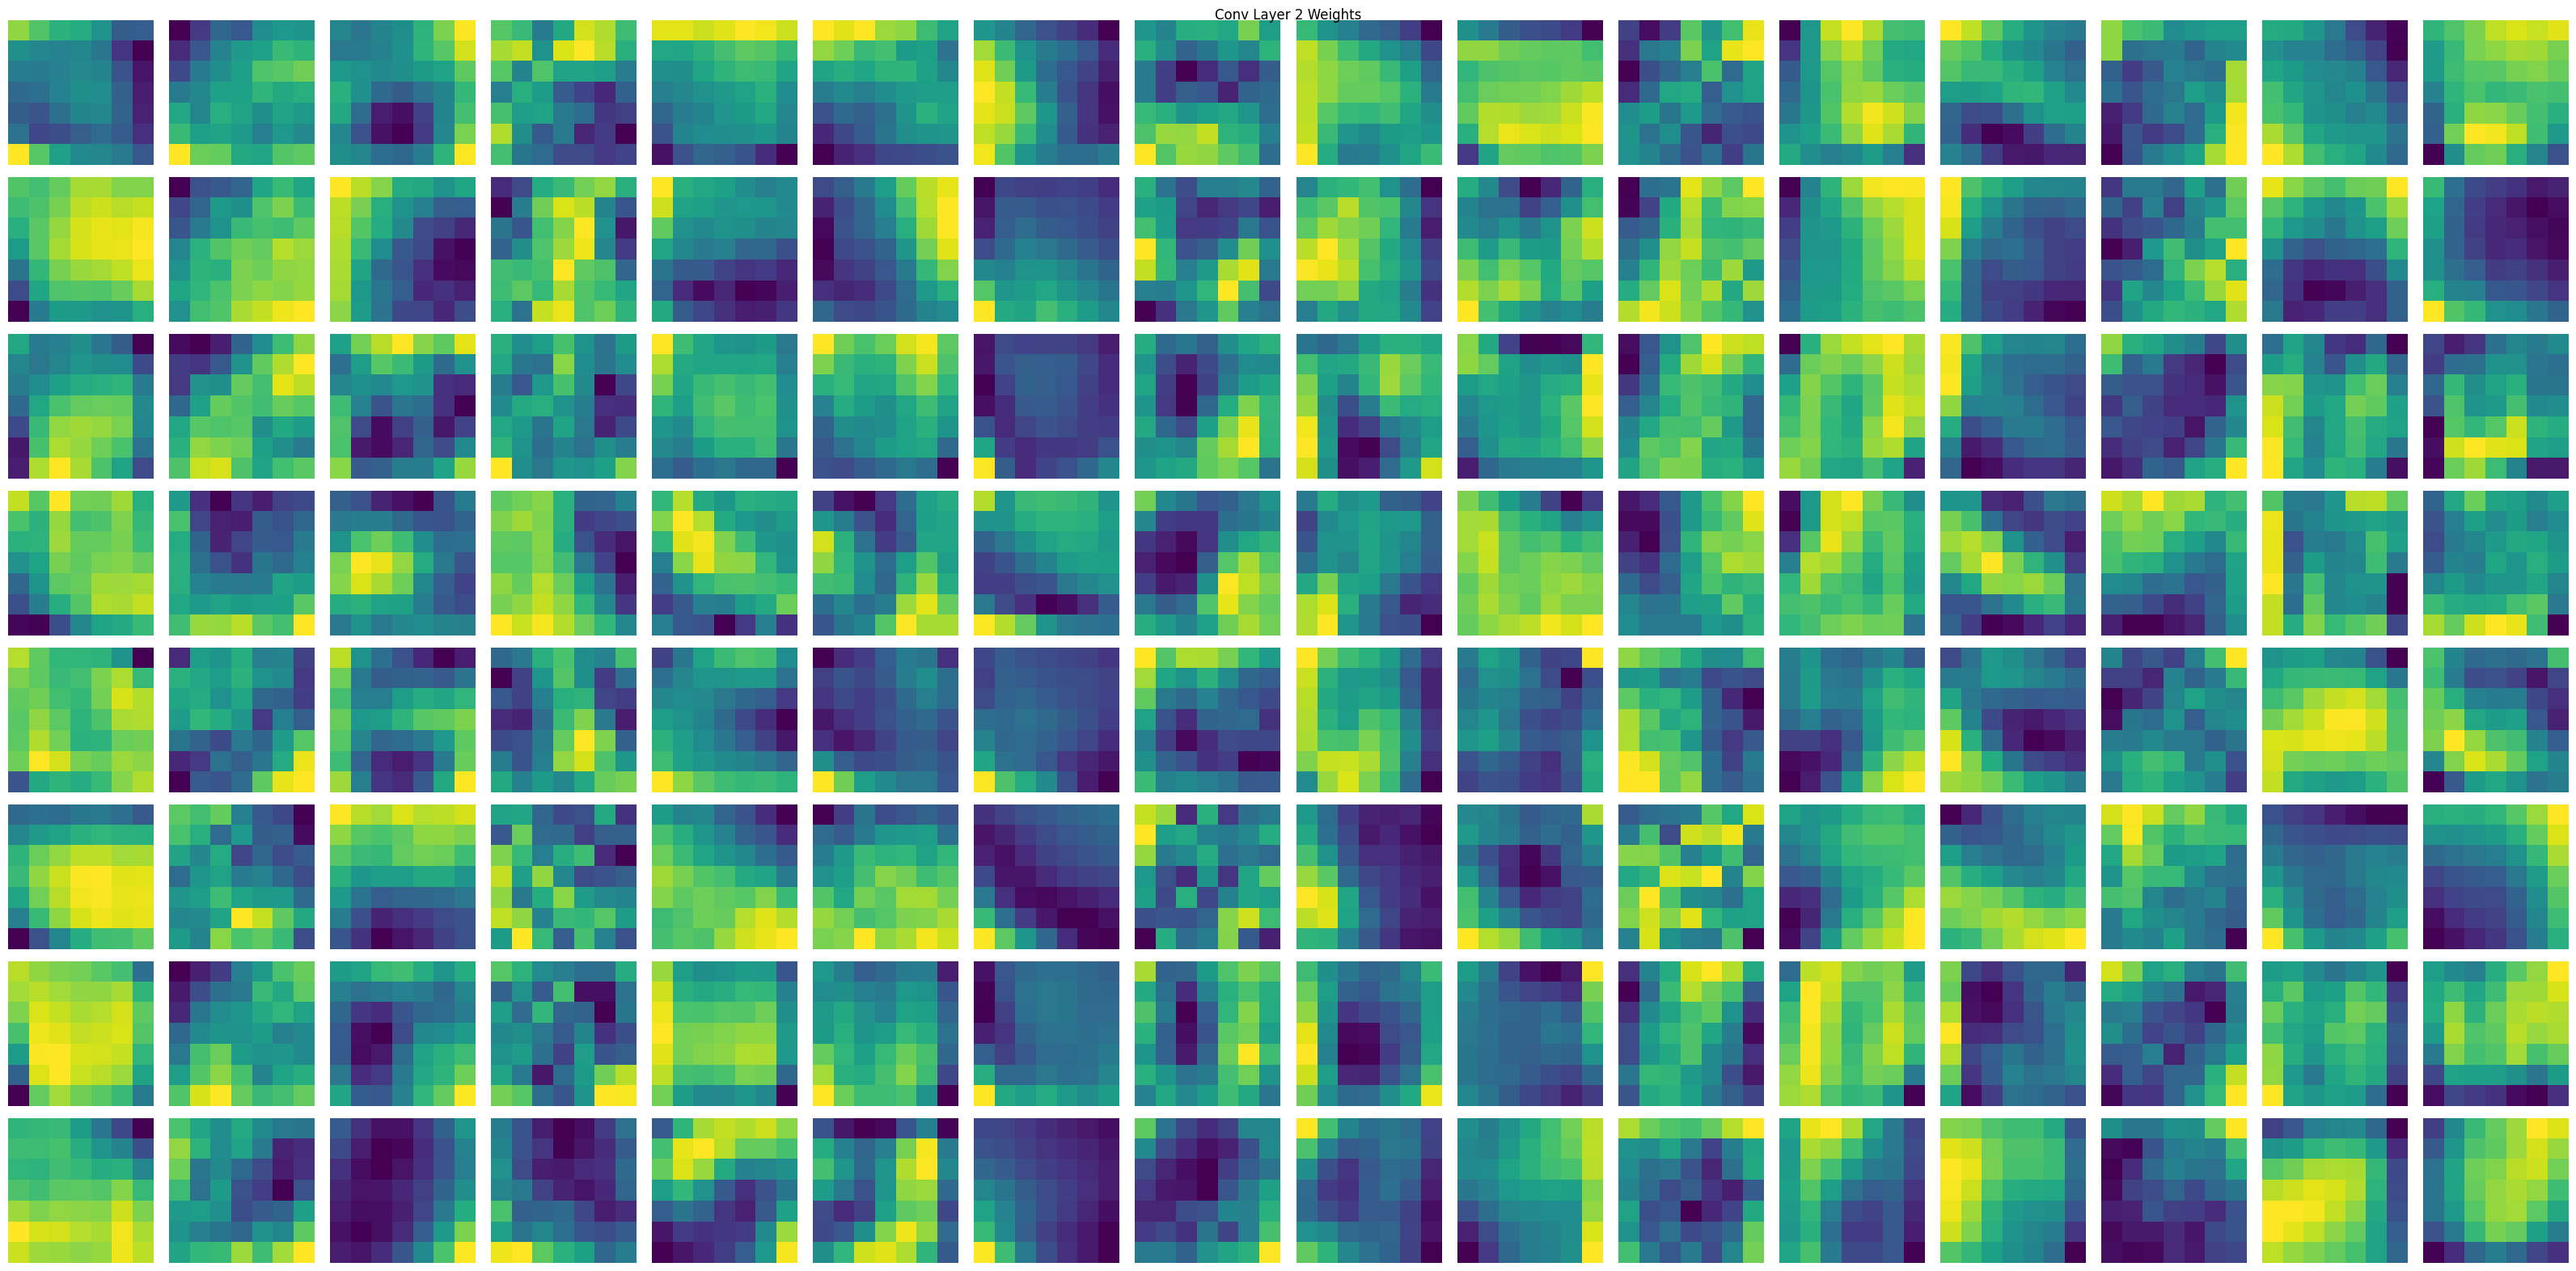

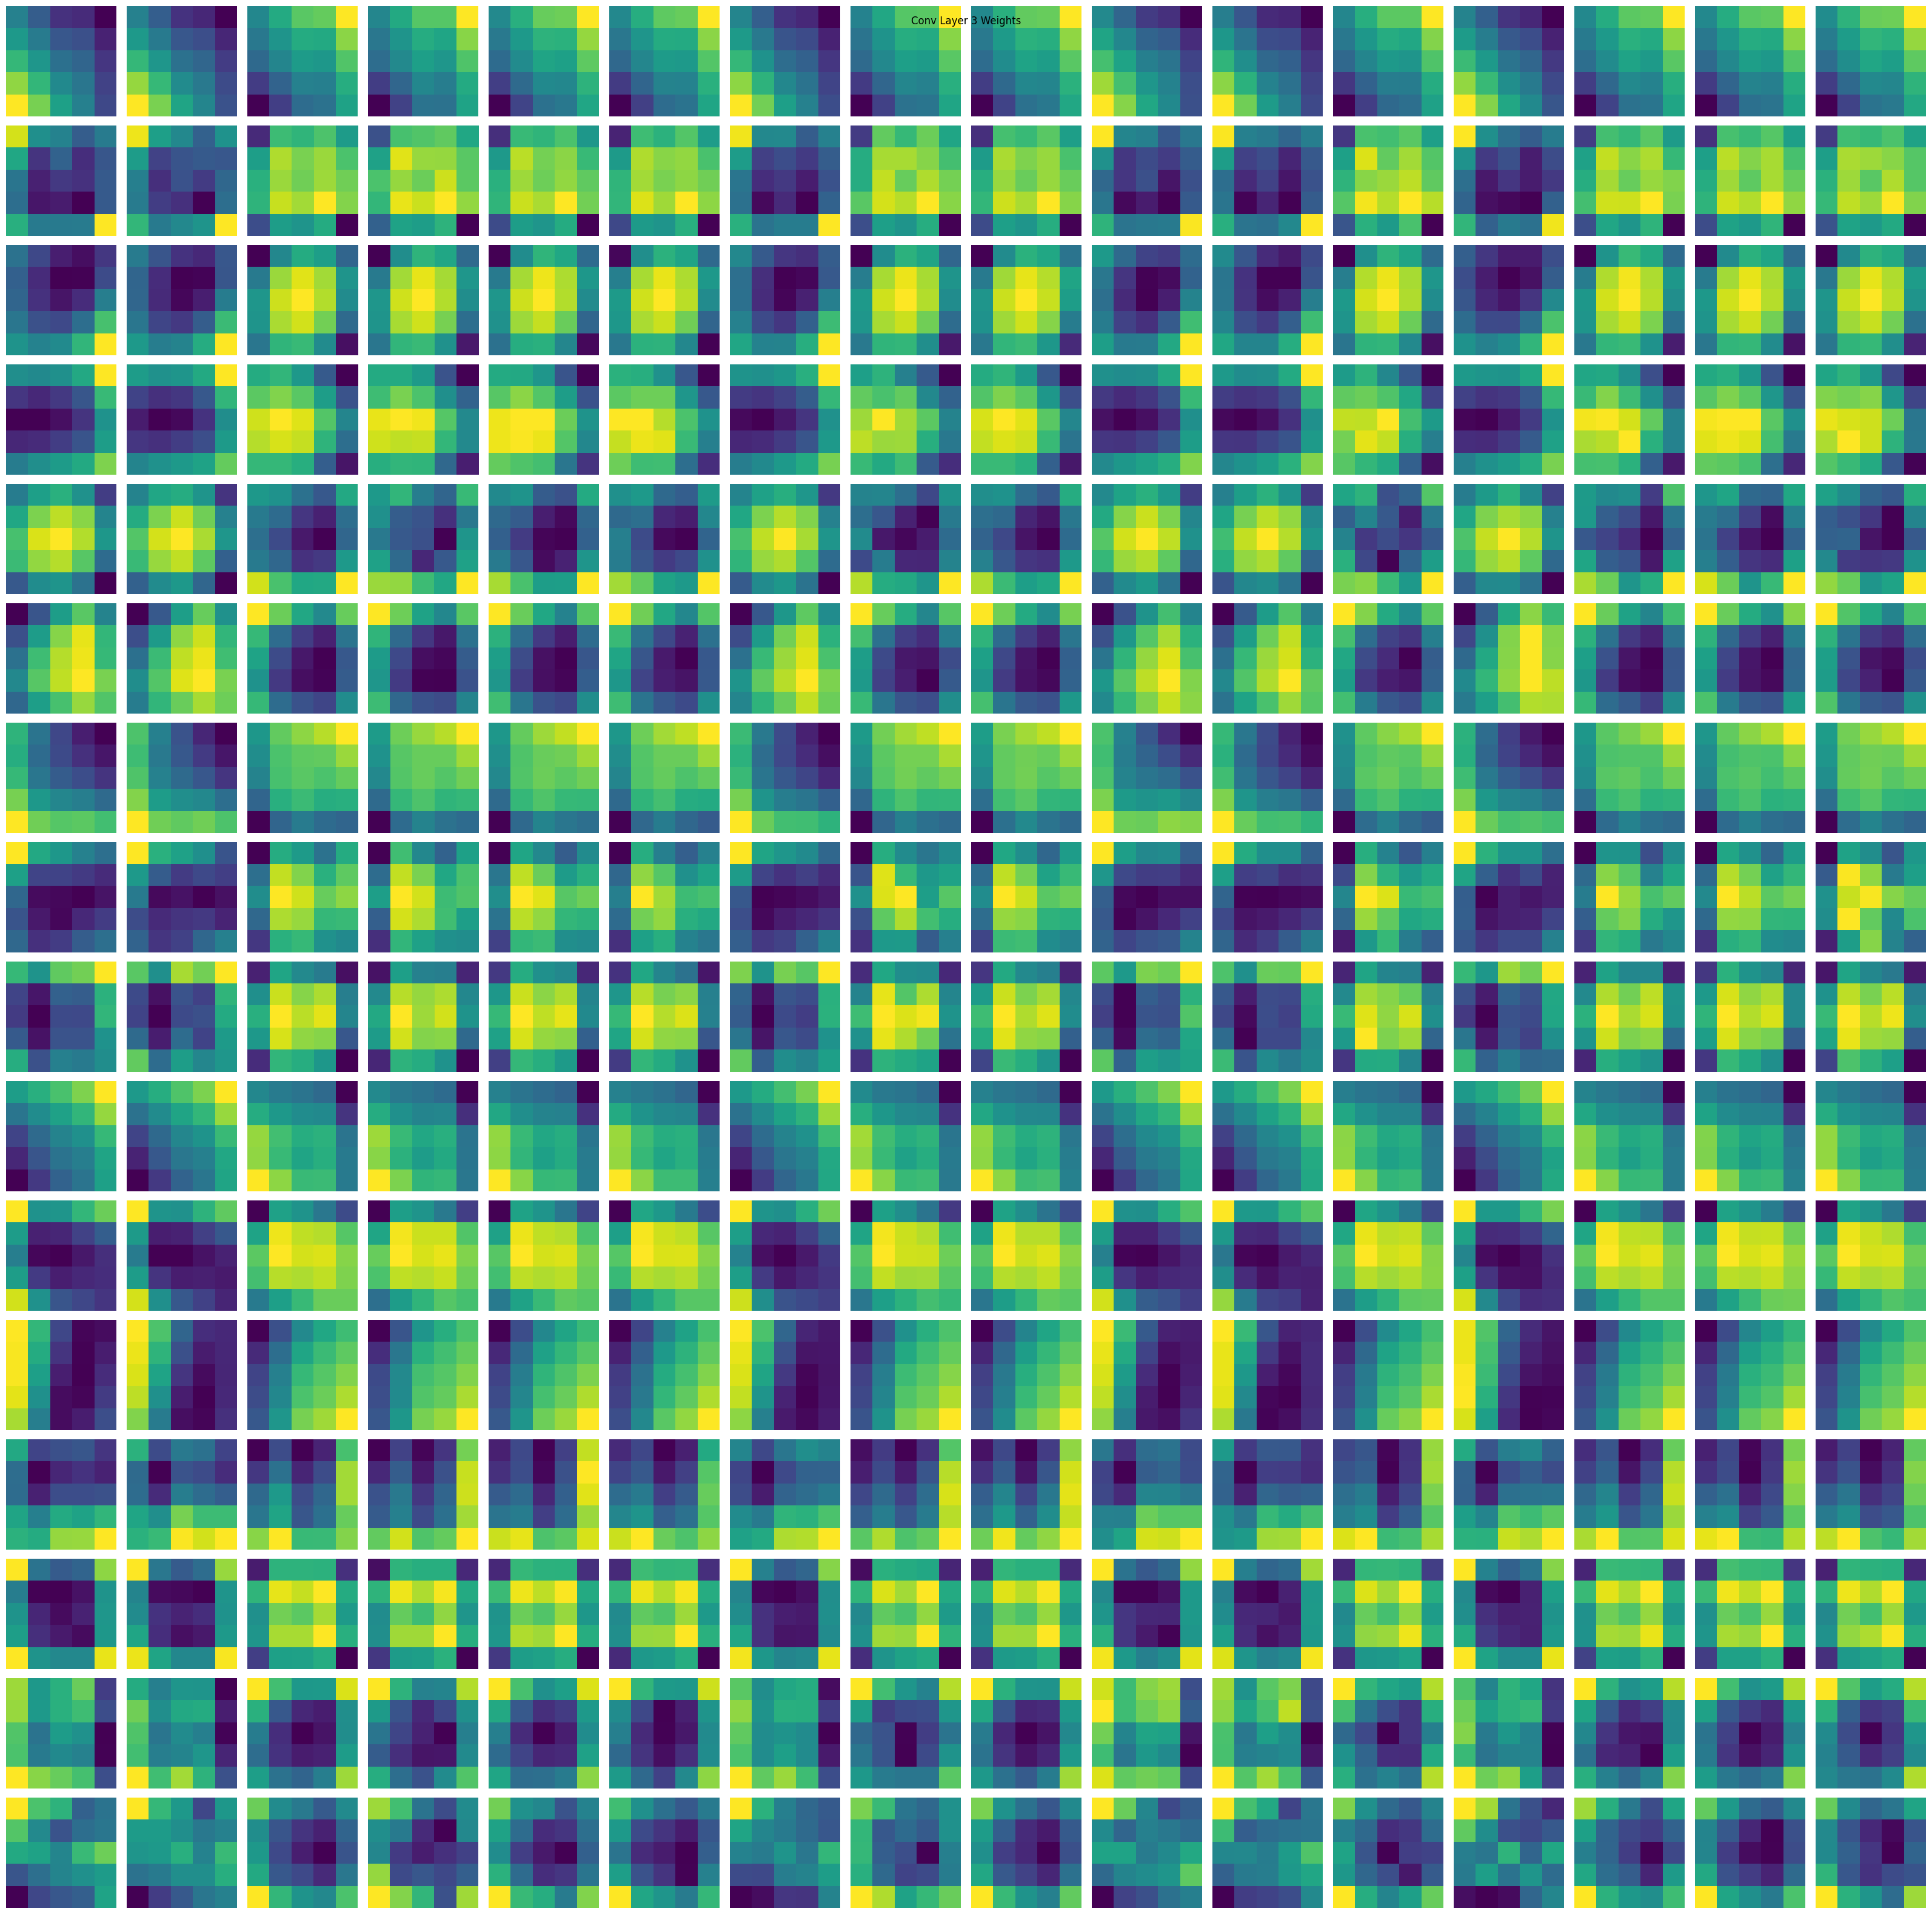

In [173]:
# inspect filters
conv_layers = []
for module in model.modules():
    if isinstance(module, torch.nn.Conv2d):
        conv_layers.append(module)

# Plot weights for each conv layer
for idx, conv_layer in enumerate(conv_layers):
    # Get weights and convert to numpy
    weights = conv_layer.weight.data.cpu().numpy()

    # Calculate grid size
    n_filters = weights.shape[0]
    n_channels = weights.shape[1]

    # Create figure
    fig, axes = plt.subplots(
        n_channels, n_filters, figsize=(n_filters * 2, n_channels * 2)
    )

    # Plot each filter's channels
    for i in range(n_filters):
        for j in range(n_channels):
            if n_channels == 1:
                ax = axes[i] if n_filters > 1 else axes
            else:
                ax = axes[j, i] if n_filters > 1 else axes[j]

            img = weights[i, j]
            ax.imshow(img, cmap="viridis")
            ax.axis("off")

    plt.suptitle(f"Conv Layer {idx+1} Weights")
    plt.tight_layout()
    plt.show()

In [174]:
## You can find the model and result corresponding to each fold in the files inside the directory

# Continue the training and validation of the model for all the other folds
for i in range(1, 10):
    # Keeping the split
    train_str = "train_" + str(i)
    val_str = "val_" + str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]

    # Create dataloaders with fold-specific normalization
    train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

    # Start the timer
    from timeit import default_timer as timer

    start_time = timer()
    # Train model
    model_results = train(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUM_EPOCHS,
        split=i,
    )
    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")
    # Extract train and validation loss and accuracy at each epoch
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and validation)
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    # Get the accuracy values of the results dictionary (training and validation)
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    # Save results in a csv
    results_df = pd.DataFrame(
        columns=["train_loss", "val_loss", "train_acc", "val_acc", "epochs"]
    )
    results_df["train_loss"] = train_loss
    results_df["val_loss"] = val_loss
    results_df["train_acc"] = train_acc
    results_df["val_acc"] = val_acc
    results_df["epochs"] = epochs
    results_df_name = basedir + "results_df_" + str(i) + ".csv"
    results_df.to_csv(results_df_name)

  2%|▏         | 1/50 [00:36<29:59, 36.72s/it]

Epoch: 1 | train_loss: 0.2129 | train_acc: 0.9214 | val_loss: 0.0950 | val_acc: 0.9824


  4%|▍         | 2/50 [01:13<29:10, 36.47s/it]

Epoch: 2 | train_loss: 0.1966 | train_acc: 0.9269 | val_loss: 0.0875 | val_acc: 0.9785


  6%|▌         | 3/50 [01:50<28:45, 36.71s/it]

Epoch: 3 | train_loss: 0.2182 | train_acc: 0.9159 | val_loss: 0.0938 | val_acc: 0.9785


  8%|▊         | 4/50 [02:27<28:16, 36.89s/it]

Epoch: 4 | train_loss: 0.2419 | train_acc: 0.9039 | val_loss: 0.1174 | val_acc: 0.9736


 10%|█         | 5/50 [03:04<27:42, 36.94s/it]

Epoch: 5 | train_loss: 0.2362 | train_acc: 0.9071 | val_loss: 0.3453 | val_acc: 0.8447


 12%|█▏        | 6/50 [03:41<27:08, 37.01s/it]

Epoch: 6 | train_loss: 0.2195 | train_acc: 0.9152 | val_loss: 0.2368 | val_acc: 0.8906


 12%|█▏        | 6/50 [04:18<31:33, 43.04s/it]


Epoch: 7 | train_loss: 0.2351 | train_acc: 0.9046 | val_loss: 0.2690 | val_acc: 0.8652
Early stopping triggered after 7 epochs
Total training time for split 1: 258.221 seconds


  2%|▏         | 1/50 [00:36<29:54, 36.63s/it]

Epoch: 1 | train_loss: 0.2414 | train_acc: 0.9049 | val_loss: 0.1495 | val_acc: 0.9424


  4%|▍         | 2/50 [01:12<29:00, 36.27s/it]

Epoch: 2 | train_loss: 0.1904 | train_acc: 0.9269 | val_loss: 0.1024 | val_acc: 0.9736


  6%|▌         | 3/50 [01:48<28:19, 36.17s/it]

Epoch: 3 | train_loss: 0.2022 | train_acc: 0.9251 | val_loss: 0.2223 | val_acc: 0.8916


  8%|▊         | 4/50 [02:24<27:43, 36.16s/it]

Epoch: 4 | train_loss: 0.2443 | train_acc: 0.9047 | val_loss: 0.1586 | val_acc: 0.9336


 10%|█         | 5/50 [03:01<27:13, 36.30s/it]

Epoch: 5 | train_loss: 0.2172 | train_acc: 0.9146 | val_loss: 0.1225 | val_acc: 0.9727


 12%|█▏        | 6/50 [03:37<26:38, 36.33s/it]

Epoch: 6 | train_loss: 0.2168 | train_acc: 0.9148 | val_loss: 0.1116 | val_acc: 0.9678


 12%|█▏        | 6/50 [04:13<31:01, 42.30s/it]


Epoch: 7 | train_loss: 0.2078 | train_acc: 0.9188 | val_loss: 1.0507 | val_acc: 0.5859
Early stopping triggered after 7 epochs
Total training time for split 2: 253.806 seconds


  2%|▏         | 1/50 [00:36<29:32, 36.17s/it]

Epoch: 1 | train_loss: 0.3779 | train_acc: 0.8292 | val_loss: 0.3174 | val_acc: 0.8379


  4%|▍         | 2/50 [01:12<28:51, 36.08s/it]

Epoch: 2 | train_loss: 0.1813 | train_acc: 0.9311 | val_loss: 0.1175 | val_acc: 0.9707


  6%|▌         | 3/50 [01:48<28:17, 36.11s/it]

Epoch: 3 | train_loss: 0.1931 | train_acc: 0.9254 | val_loss: 0.1020 | val_acc: 0.9805


  8%|▊         | 4/50 [02:24<27:44, 36.19s/it]

Epoch: 4 | train_loss: 0.2234 | train_acc: 0.9149 | val_loss: 0.1633 | val_acc: 0.9385


 10%|█         | 5/50 [03:00<27:06, 36.15s/it]

Epoch: 5 | train_loss: 0.2244 | train_acc: 0.9111 | val_loss: 0.1389 | val_acc: 0.9443


 12%|█▏        | 6/50 [03:37<26:33, 36.21s/it]

Epoch: 6 | train_loss: 0.2188 | train_acc: 0.9167 | val_loss: 0.1293 | val_acc: 0.9688


 14%|█▍        | 7/50 [04:13<25:55, 36.17s/it]

Epoch: 7 | train_loss: 0.2041 | train_acc: 0.9227 | val_loss: 0.1570 | val_acc: 0.9395


 14%|█▍        | 7/50 [04:49<29:37, 41.33s/it]


Epoch: 8 | train_loss: 0.2260 | train_acc: 0.9102 | val_loss: 0.2615 | val_acc: 0.8770
Early stopping triggered after 8 epochs
Total training time for split 3: 289.316 seconds


  2%|▏         | 1/50 [00:36<30:06, 36.87s/it]

Epoch: 1 | train_loss: 0.2090 | train_acc: 0.9193 | val_loss: 0.0934 | val_acc: 0.9707


  4%|▍         | 2/50 [01:13<29:27, 36.83s/it]

Epoch: 2 | train_loss: 0.1833 | train_acc: 0.9313 | val_loss: 0.0778 | val_acc: 0.9854


  6%|▌         | 3/50 [01:51<29:06, 37.15s/it]

Epoch: 3 | train_loss: 0.1921 | train_acc: 0.9261 | val_loss: 0.0956 | val_acc: 0.9648


  8%|▊         | 4/50 [02:29<28:50, 37.61s/it]

Epoch: 4 | train_loss: 0.2050 | train_acc: 0.9193 | val_loss: 0.6708 | val_acc: 0.6650


 10%|█         | 5/50 [03:08<28:32, 38.06s/it]

Epoch: 5 | train_loss: 0.2242 | train_acc: 0.9153 | val_loss: 0.1102 | val_acc: 0.9541


 12%|█▏        | 6/50 [03:46<28:02, 38.24s/it]

Epoch: 6 | train_loss: 0.1892 | train_acc: 0.9291 | val_loss: 0.3231 | val_acc: 0.8379


 12%|█▏        | 6/50 [04:26<32:32, 44.38s/it]


Epoch: 7 | train_loss: 0.2070 | train_acc: 0.9188 | val_loss: 0.1224 | val_acc: 0.9775
Early stopping triggered after 7 epochs
Total training time for split 4: 266.265 seconds


  2%|▏         | 1/50 [00:38<31:46, 38.91s/it]

Epoch: 1 | train_loss: 0.2377 | train_acc: 0.9054 | val_loss: 0.1048 | val_acc: 0.9766


  4%|▍         | 2/50 [01:17<30:45, 38.45s/it]

Epoch: 2 | train_loss: 0.1671 | train_acc: 0.9391 | val_loss: 0.1055 | val_acc: 0.9697


  6%|▌         | 3/50 [01:54<29:51, 38.12s/it]

Epoch: 3 | train_loss: 0.1833 | train_acc: 0.9290 | val_loss: 0.0793 | val_acc: 0.9912


  8%|▊         | 4/50 [02:32<28:58, 37.80s/it]

Epoch: 4 | train_loss: 0.2214 | train_acc: 0.9132 | val_loss: 0.7071 | val_acc: 0.6768


 10%|█         | 5/50 [03:09<28:12, 37.62s/it]

Epoch: 5 | train_loss: 0.1974 | train_acc: 0.9241 | val_loss: 0.1835 | val_acc: 0.9248


 12%|█▏        | 6/50 [03:46<27:29, 37.49s/it]

Epoch: 6 | train_loss: 0.1862 | train_acc: 0.9281 | val_loss: 0.1100 | val_acc: 0.9795


 14%|█▍        | 7/50 [04:24<26:56, 37.60s/it]

Epoch: 7 | train_loss: 0.2094 | train_acc: 0.9199 | val_loss: 0.4476 | val_acc: 0.7881


 14%|█▍        | 7/50 [05:02<30:56, 43.17s/it]


Epoch: 8 | train_loss: 0.2072 | train_acc: 0.9176 | val_loss: 0.1051 | val_acc: 0.9688
Early stopping triggered after 8 epochs
Total training time for split 5: 302.189 seconds


  2%|▏         | 1/50 [00:38<31:32, 38.63s/it]

Epoch: 1 | train_loss: 0.1749 | train_acc: 0.9359 | val_loss: 0.0858 | val_acc: 0.9785


  4%|▍         | 2/50 [01:16<30:44, 38.43s/it]

Epoch: 2 | train_loss: 0.1631 | train_acc: 0.9413 | val_loss: 0.0845 | val_acc: 0.9775


  6%|▌         | 3/50 [01:55<30:00, 38.31s/it]

Epoch: 3 | train_loss: 0.1688 | train_acc: 0.9371 | val_loss: 0.1033 | val_acc: 0.9746


  8%|▊         | 4/50 [02:32<29:13, 38.13s/it]

Epoch: 4 | train_loss: 0.2098 | train_acc: 0.9222 | val_loss: 0.1807 | val_acc: 0.9297


 10%|█         | 5/50 [03:11<28:43, 38.31s/it]

Epoch: 5 | train_loss: 0.1824 | train_acc: 0.9300 | val_loss: 0.1694 | val_acc: 0.9277


 12%|█▏        | 6/50 [03:50<28:10, 38.43s/it]

Epoch: 6 | train_loss: 0.1751 | train_acc: 0.9364 | val_loss: 0.4614 | val_acc: 0.8115


 12%|█▏        | 6/50 [04:28<32:50, 44.78s/it]


Epoch: 7 | train_loss: 0.1823 | train_acc: 0.9331 | val_loss: 0.0856 | val_acc: 0.9746
Early stopping triggered after 7 epochs
Total training time for split 6: 268.695 seconds


  2%|▏         | 1/50 [00:38<31:35, 38.68s/it]

Epoch: 1 | train_loss: 0.1695 | train_acc: 0.9400 | val_loss: 0.0742 | val_acc: 0.9795


  4%|▍         | 2/50 [01:17<30:50, 38.56s/it]

Epoch: 2 | train_loss: 0.1492 | train_acc: 0.9477 | val_loss: 0.0547 | val_acc: 0.9932


  6%|▌         | 3/50 [01:55<30:01, 38.33s/it]

Epoch: 3 | train_loss: 0.1624 | train_acc: 0.9409 | val_loss: 0.0799 | val_acc: 0.9756


  8%|▊         | 4/50 [02:33<29:26, 38.41s/it]

Epoch: 4 | train_loss: 0.1761 | train_acc: 0.9338 | val_loss: 0.0891 | val_acc: 0.9697


 10%|█         | 5/50 [03:12<28:55, 38.56s/it]

Epoch: 5 | train_loss: 0.1720 | train_acc: 0.9333 | val_loss: 0.0837 | val_acc: 0.9834


 12%|█▏        | 6/50 [03:51<28:17, 38.58s/it]

Epoch: 6 | train_loss: 0.1760 | train_acc: 0.9342 | val_loss: 0.2821 | val_acc: 0.8613


 12%|█▏        | 6/50 [04:30<33:00, 45.02s/it]


Epoch: 7 | train_loss: 0.1685 | train_acc: 0.9381 | val_loss: 0.1602 | val_acc: 0.9414
Early stopping triggered after 7 epochs
Total training time for split 7: 270.132 seconds


  2%|▏         | 1/50 [00:39<32:08, 39.35s/it]

Epoch: 1 | train_loss: 0.1712 | train_acc: 0.9353 | val_loss: 0.0766 | val_acc: 0.9883


  4%|▍         | 2/50 [01:17<30:59, 38.74s/it]

Epoch: 2 | train_loss: 0.1431 | train_acc: 0.9496 | val_loss: 0.1053 | val_acc: 0.9629


  6%|▌         | 3/50 [01:56<30:32, 39.00s/it]

Epoch: 3 | train_loss: 0.1608 | train_acc: 0.9371 | val_loss: 0.0713 | val_acc: 0.9814


  8%|▊         | 4/50 [02:36<29:59, 39.12s/it]

Epoch: 4 | train_loss: 0.1562 | train_acc: 0.9417 | val_loss: 0.0672 | val_acc: 0.9785


 10%|█         | 5/50 [03:14<29:10, 38.91s/it]

Epoch: 5 | train_loss: 0.1664 | train_acc: 0.9358 | val_loss: 0.1769 | val_acc: 0.9287


 12%|█▏        | 6/50 [03:53<28:27, 38.81s/it]

Epoch: 6 | train_loss: 0.1588 | train_acc: 0.9389 | val_loss: 0.1662 | val_acc: 0.9268


 14%|█▍        | 7/50 [04:32<27:46, 38.76s/it]

Epoch: 7 | train_loss: 0.1645 | train_acc: 0.9392 | val_loss: 0.0926 | val_acc: 0.9678


 16%|█▌        | 8/50 [05:10<27:08, 38.77s/it]

Epoch: 8 | train_loss: 0.1641 | train_acc: 0.9366 | val_loss: 0.0595 | val_acc: 0.9902


 18%|█▊        | 9/50 [05:49<26:34, 38.88s/it]

Epoch: 9 | train_loss: 0.1681 | train_acc: 0.9363 | val_loss: 0.2727 | val_acc: 0.8828


 20%|██        | 10/50 [06:29<26:00, 39.01s/it]

Epoch: 10 | train_loss: 0.1840 | train_acc: 0.9316 | val_loss: 0.0752 | val_acc: 0.9805


 22%|██▏       | 11/50 [07:08<25:23, 39.07s/it]

Epoch: 11 | train_loss: 0.1695 | train_acc: 0.9365 | val_loss: 0.2139 | val_acc: 0.9053


 24%|██▍       | 12/50 [07:47<24:44, 39.07s/it]

Epoch: 12 | train_loss: 0.1670 | train_acc: 0.9376 | val_loss: 0.2218 | val_acc: 0.9004


 24%|██▍       | 12/50 [08:26<26:45, 42.25s/it]


Epoch: 13 | train_loss: 0.1616 | train_acc: 0.9397 | val_loss: 0.1522 | val_acc: 0.9355
Early stopping triggered after 13 epochs
Total training time for split 8: 506.965 seconds


  2%|▏         | 1/50 [00:38<31:48, 38.95s/it]

Epoch: 1 | train_loss: 0.1433 | train_acc: 0.9498 | val_loss: 0.0658 | val_acc: 0.9814


  4%|▍         | 2/50 [01:17<31:07, 38.90s/it]

Epoch: 2 | train_loss: 0.1403 | train_acc: 0.9506 | val_loss: 0.1054 | val_acc: 0.9629


  6%|▌         | 3/50 [01:56<30:21, 38.76s/it]

Epoch: 3 | train_loss: 0.1389 | train_acc: 0.9488 | val_loss: 0.0811 | val_acc: 0.9785


  8%|▊         | 4/50 [02:34<29:38, 38.67s/it]

Epoch: 4 | train_loss: 0.1586 | train_acc: 0.9433 | val_loss: 0.2222 | val_acc: 0.8975


 10%|█         | 5/50 [03:13<28:58, 38.63s/it]

Epoch: 5 | train_loss: 0.1562 | train_acc: 0.9424 | val_loss: 0.0652 | val_acc: 0.9873


 10%|█         | 5/50 [03:52<34:48, 46.41s/it]

Epoch: 6 | train_loss: 0.1524 | train_acc: 0.9424 | val_loss: 0.1152 | val_acc: 0.9600
Early stopping triggered after 6 epochs
Total training time for split 9: 232.066 seconds


In [175]:
# Loading the checkpoint
def load_checkpoint(filepath):
    # Carichiamo i checkpoint in modalità sicura specificando weights_only=False
    checkpoint = torch.load(
        filepath, map_location=torch.device(device), weights_only=False
    )
    model = ImageClassifier().to(device)  # Creiamo prima il modello
    model.load_state_dict(checkpoint["state_dict"])  # Carichiamo solo i pesi
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [176]:
def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Avoid division by zero
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) != 0
        else 0
    )
    return f1


def accuracy_score(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    accuracy = correct / len(y_true)
    return accuracy


def compute_metrics(model, dataloader):
    model.eval()
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true = np.concatenate((y_true, labels.cpu().numpy()))
            y_pred = np.concatenate((y_pred, y_pred_class.cpu().numpy()))

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, f1


accuracies = []
f1_scores = []
# Iterate through all folds (0-9)
for i in range(10):
    model = load_checkpoint(basedir + "checkpoint_" + str(i) + ".pth")
    train_str = "train_" + str(i)
    val_str = "val_" + str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]
    _, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)
    accuracy, f1 = compute_metrics(model, val_loader)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    print(f"Accuracy for split {i}: {accuracy}")
    print(f"F1 Score for split {i}: {f1}")


mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean F1 Score: {mean_f1_score}")

Accuracy for split 0: 0.976
F1 Score for split 0: 0.9762845849802372
Accuracy for split 1: 0.982
F1 Score for split 1: 0.982283464566929
Accuracy for split 2: 0.976
F1 Score for split 2: 0.9764705882352941
Accuracy for split 3: 0.98
F1 Score for split 3: 0.9800399201596806
Accuracy for split 4: 0.985
F1 Score for split 4: 0.985192497532083
Accuracy for split 5: 0.991
F1 Score for split 5: 0.991044776119403
Accuracy for split 6: 0.978
F1 Score for split 6: 0.977867203219316
Accuracy for split 7: 0.993
F1 Score for split 7: 0.9930486593843098
Accuracy for split 8: 0.99
F1 Score for split 8: 0.9900793650793651
Accuracy for split 9: 0.987
F1 Score for split 9: 0.986986986986987
Mean Accuracy: 0.9837999999999999
Mean F1 Score: 0.9839298046263604


In [177]:
from captum.attr import Occlusion

# Load the model
model = load_checkpoint(basedir + "checkpoint_9.pth")

# Get a single image from the validation set
images, labels = next(iter(val_loader))
random_idx = random.randint(0, len(images) - 1)
image = images[random_idx].unsqueeze(0).to(device)
label = labels[random_idx].unsqueeze(0).to(device)

# Create an Occlusion object
occlusion = Occlusion(model)

# Compute the attribution
attribution = occlusion.attribute(
    image, target=label, sliding_window_shapes=(1, 32, 32)
)

Text(0.5, 1.0, 'Occlusion Attribution Map')

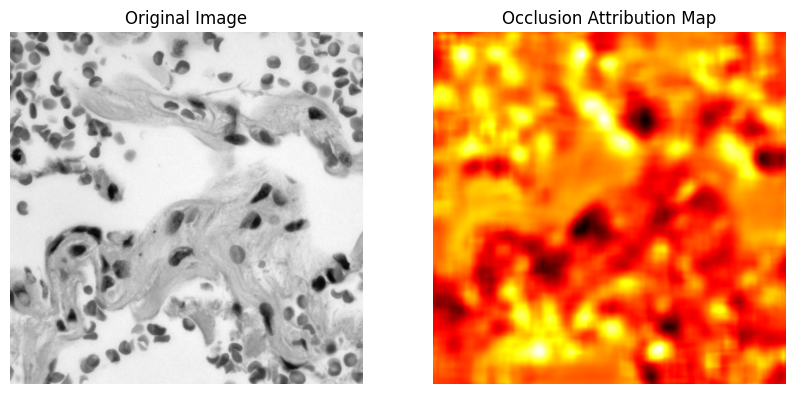

In [178]:
# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze().cpu().numpy(), cmap="gray")
plt.axis("off")
plt.title("Original Image")

# Plot the attribution map
plt.subplot(1, 2, 2)
plt.imshow(attribution.squeeze().cpu().numpy(), cmap="hot")
plt.axis("off")
plt.title("Occlusion Attribution Map")

In [179]:
from captum.attr import Saliency

# Load the model
model = load_checkpoint(basedir + "checkpoint_9.pth")

# Create a Saliency object
saliency = Saliency(model)

# Compute the attribution
attribution = saliency.attribute(image, target=label)

/home/lore/Documents/GitHub/VisualIntelligence/.venv/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Text(0.5, 1.0, 'Occlusion Attribution Map')

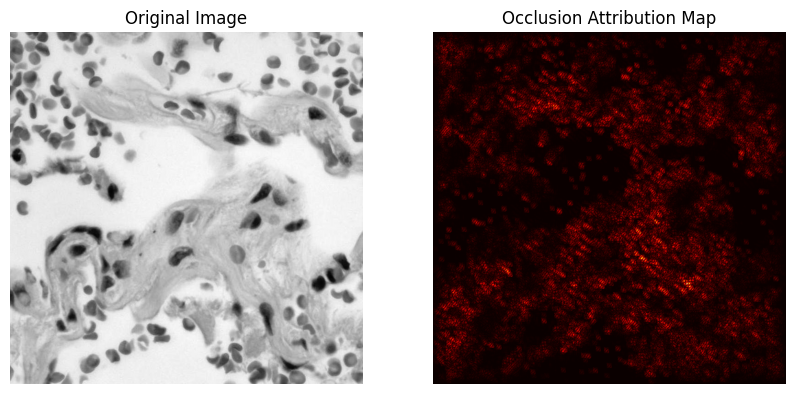

In [180]:
# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze().cpu().numpy(), cmap="gray")
plt.axis("off")
plt.title("Original Image")

# Plot the attribution map
plt.subplot(1, 2, 2)
plt.imshow(attribution.squeeze().cpu().numpy(), cmap="hot")
plt.axis("off")
plt.title("Occlusion Attribution Map")